# Retrieving Pseudo-MPC Observations for JUICE

## Objectives
In this example show how to retrieve pseudo-MPEC data from a **selected webpage** that does not belong to any of the [official sources](https://astroquery.readthedocs.io/en/latest/index.html#available-services) used by astroquery. Check out the [Workflow section](#Workflow) for an exaplanation of why this might turn out to àbe useuful. We will then use the Tudat Horizons interface to compare observation ouput. 

## Key API References

## Import Statements
First, let's import the relevant modules we will be using throughout this example.
Apart from the usual tudatpy modules, we will also need the HorizonsQuery module, some astroquery modules (MPC, Table, Column) and the BeautifulSoup library.

In [6]:
from tudatpy.data.mpc import BatchMPC
from tudatpy.kernel.numerical_simulation import environment_setup
from tudatpy.kernel.numerical_simulation.estimation_setup import observation
from tudatpy.kernel.interface import spice
from tudatpy.data.horizons import HorizonsQuery
from tudatpy.kernel.numerical_simulation import environment_setup
from tudatpy.kernel import numerical_simulation
from tudatpy.kernel.numerical_simulation.estimation_setup import observation
from astropy.time import Time
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import os

from astroquery.mpc import MPC
import requests
import re
from tudatpy import constants

from astropy.table import Table, Column
from bs4 import BeautifulSoup

### Importing Kernels
We also load the standard kernels, also making sure to add the latest JUICE orbital one.

In [7]:
# Load spice kernels
spice.load_standard_kernels()

# Load spice kernels
path = os.getcwd()
kernels = [path+'/juice_orbc_000073_230414_310721_v01.bsp']
spice.load_standard_kernels(kernels)

## Workflow
<a id='Workflow'></a>
In [the previous example](https://docs.tudat.space/en/latest/_src_getting_started/_src_examples/tudatpy-examples/estimation/retrieving_mpc_observation_data.html), we explained how to retrieve **optical data** from the [Minor Planet Centre](https://www.minorplanetcenter.net/). The MPC receives and stores optical observations  (RA and DEC) of natural objects (asteroids, comets, minor planets) from observatories across the world and stores them into Minor Planet Electronic Circulars (MPECs). However, not all objects falling in the Field of View of an optical telescope are natural bodies: in some cases, artificial objects (such as space missions) can be tracked by optical telescopes as well. This was recently the case for the JUICE mission, for which some optical observations have been collected by observatories around the world. You won't find JUICE astrometry on the MPC, but it can be found at [this webpage](https://www.projectpluto.com/pluto/mpecs/23053a.htm#ast) in the form of a pseudo-MPEC.

Unlike what shown in the MPC example, we cannot directly initialize a BatchMPC object for JUICE, since astroquery is only able to retrieve data from [official sources](https://astroquery.readthedocs.io/en/latest/index.html#available-services). We therefore need to:

1) parse the html page containing the wanted data, retrieving information (observation times, angular observables, station codes, observation bands, etc...).
2) feed this information into a table that has the same format as the one created by tudat using the `.get_observations()`.
3) convert the newly created table into a `Batch.MPC` object using the `.from_astropy()` function.
### 1) Parsing the html page
For this step, we need to parse the html page containing the JUICE astrometry. This step is - in general - highly webpage-dependent. This example is tailored to the JUICE astrometry collected by astronomer Bill Gray and stored in his [website](https://projectpluto.com). In this cell, we parse the html and retrieve observations epoch and number, angular coordinates, observation bands and observatories codes for (most) observations present in the webpage. 

In [8]:
MPC.query_object = requests.get("https://www.projectpluto.com/pluto/mpecs/23053a.htm", "-28")

observations = MPC.query_object.text #use this if you want the whole html page

# Find the position of the <a name="stations"></a> tag
match = re.search(r'<a name="stations"></a>', observations)
if match:
    # Keep only the part of the HTML before the matched line
    html_cleaned = observations[:match.start()]
    
match = re.search(r'<a href="https://www.projectpluto.com/mpec_xpl.htm#astrometry"> <b>Astrometry:</b> </a>', html_cleaned)
if match:
    # Keep only the part of the HTML before the matched line
    html_cleaned = html_cleaned[match.end():].lstrip()
observations = [line.strip() for line in html_cleaned.splitlines() if line.strip()]

# Initialize lists to hold the extracted data
obs_numbers = []
epochs = []
RAs = []
DECs = []
bands = []
observatories = []

for i,observation_string in enumerate(observations):
    soup = BeautifulSoup(observation_string, 'html.parser')
    obs_number = i+1
    
    # Extract the observation string (without the band and observatory)
    observation_string = soup.get_text().split(soup.find_all('a')[1].get_text())[1].split(soup.find_all('a')[2].get_text())[0].strip()
    if observation_string[2] == 'K':
        print(f'Skipping Observation Line (Unconsistent Obs. Epoch):\n{observation_string}') #Skip badly formatted lines
        continue
        
    # Extract and parse date and time
    if observation_string[0:2] == 'KC' or observation_string[0:2] == '0C' or observation_string[0:2] == '3C' or observation_string[0:2] == 'KB':
        year = observation_string[2:6]
        month = observation_string[7:9]
        date_part, frac_day = observation_string[10:19].split('.')
        obs_numbers.append(obs_number)
    elif observation_string[0] == 'C':
        year = observation_string[1:5] 
        month = observation_string[6:8]
        date_part, frac_day = observation_string[9:18].split('.')
        obs_numbers.append(obs_number)
    

    # Calculate the time in hours, minutes, seconds
    hours = float("0." + frac_day) * 24
    minutes = (hours % 1) * 60
    seconds = (minutes % 1) * 60
    seconds_int = int(seconds)
    microseconds = int((seconds - seconds_int) * 1_000_000)
    
    if round(seconds) == 60: 
        minutes = minutes + 1
        seconds = 0
        
    # Convert to Julian date
    time_string = f"{date_part} {int(hours):02}:{int(minutes):02}:{seconds:02}"
    epoch = f'{year}-{month}-{date_part} {int(hours):02}:{int(minutes):02}:{seconds_int:02}.{microseconds:06}'
    dt = datetime.strptime(epoch, "%Y-%m-%d %H:%M:%S.%f")
    dt_jd = Time(dt).jd
    epochs.append(dt_jd)


    # Extract RA and DEC
    if observation_string[0:2] == 'KC' or observation_string[0:2] == '0C' or observation_string[0:2] == '3C' or observation_string[0:2] == 'KB':
        ra_dec_str = observation_string[19:45]  # RA and DEC part, RA in hours, DEC in degrees
        ra_part = ra_dec_str[:12].strip()  # Right Ascension
        dec_part = ra_dec_str[12:].strip()  # Declination

        #Right Ascension
        parts_RA = ra_part.split()
        hours_RA = float(parts_RA[0]) 
        minutes_RA = float(parts_RA[1]) if len(parts_RA) > 1 else 0
        seconds_RA = float(parts_RA[2]) if len(parts_RA) > 2 else 0
        deg_ra = 15*hours_RA + 0.25*minutes_RA + seconds_RA/240

        #Declination
        parts_DEC = dec_part.split()
        degrees_DEC = float(parts_DEC[0])
        minutes_DEC = float(parts_DEC[1]) if len(parts_DEC) > 1 else 0
        seconds_DEC = float(parts_DEC[2]) if len(parts_DEC) > 2 else 0
        if len(parts_DEC[0]) == 3:
            deg_dec = - (abs(degrees_DEC) + minutes_DEC / 60 + seconds_DEC / 3600)
        else:
            deg_dec = (abs(degrees_DEC) + minutes_DEC/ 60 + seconds_DEC/ 3600)
            
        # Extract Band
        band = observation_string[57:58]
        bands.append(band)

    elif observation_string[0] == 'C':
        ra_dec_str = observation_string[18:45]  # RA and DEC part
        ra_part = ra_dec_str[:12].strip()  # Right Ascension
        dec_part = ra_dec_str[12:].strip()  # Declination (considering no space if negative)

        #Right Ascension
        parts_RA = ra_part.split()
        hours_RA = float(parts_RA[0])
        minutes_RA = float(parts_RA[1]) if len(parts_RA) > 1 else 0
        seconds_RA = float(parts_RA[2]) if len(parts_RA) > 2 else 0
        deg_ra = 15*hours_RA + 0.25*minutes_RA + seconds_RA/240

        #Declination
        parts_DEC = dec_part.split()
        degrees_DEC = float(parts_DEC[0])
        minutes_DEC = float(parts_DEC[1]) if len(parts_DEC) > 1 else 0
        seconds_DEC = float(parts_DEC[2]) if len(parts_DEC) > 2 else 0
        if len(parts_DEC[0]) == 3:
            deg_dec = - (abs(degrees_DEC) + minutes_DEC/ 60 + seconds_DEC/ 3600) #in degrees
        else:
            deg_dec = (abs(degrees_DEC) + minutes_DEC/ 60 + seconds_DEC/ 3600) #in degrees
            
        # Extract Band
        band = observation_string[57:58]
        bands.append(band)

    # Extract the observatory code
    observatory = soup.find_all('a')[2].get_text().strip()
    observatories.append(observatory)
    rad_ra = (np.radians(deg_ra) + np.pi) % (2*np.pi) - np.pi #Normalize RA to the interval [-pi,pi]
    RAs.append(np.degrees(rad_ra)) #in degrees
    DECs.append(deg_dec) #in degrees

Skipping Observation Line (Unconsistent Obs. Epoch):
KCK240804:23280637 22 36 18.050-09 19 10.78         19.4 GV
Skipping Observation Line (Unconsistent Obs. Epoch):
KCK240806:22560267 22 36 25.068-09 21 57.31         19.5 GV
Skipping Observation Line (Unconsistent Obs. Epoch):
KCK240806:23003128 22 36 24.830-09 21 58.64         19.1 GV
Skipping Observation Line (Unconsistent Obs. Epoch):
KCK240806:23045741 22 36 24.626-09 21 59.00         19.8 GV
Skipping Observation Line (Unconsistent Obs. Epoch):
KCK240806:23092838 22 36 24.389-09 21 59.36         19.4 GV
Skipping Observation Line (Unconsistent Obs. Epoch):
KBK240817:0306227  22 29 24.481-10 44 44.68         17.0 VZ
Skipping Observation Line (Unconsistent Obs. Epoch):
KBK240817:0310286  22 29 22.708-10 44 50.54         17.0 VZ
Skipping Observation Line (Unconsistent Obs. Epoch):
KBK240817:0314277  22 29 20.969-10 44 56.16         16.8 VZ


Note that RA and Dec are given in **degrees** (they could be given in radians, but we leave it this way to be consistent with the previous JUICE example).

### 2) Feeding the table
 Now it's time to create and feed a table with the data we just retrieved. The table has to be given in the same format as the one shown in the MPC example.

In [9]:
# Create the table
table = Table()

# Add columns to the table
table.add_column(Column(name='number', data= np.transpose(['-28']*len(obs_numbers))))
table.add_column(Column(name='designation', data= np.transpose(['JUICE']*len(obs_numbers))))
table.add_column(Column(name='discovery', data= np.transpose(['NaN']*len(obs_numbers))))
table.add_column(Column(name='note1', data= np.transpose(['NaN']*len(obs_numbers))))
table.add_column(Column(name='note2', data= np.transpose(['NaN']*len(obs_numbers))))
table.add_column(Column(name='epoch', data=epochs))
table.add_column(Column(name='RA', data=RAs, unit='deg'))  # RA in degrees
table.add_column(Column(name='DEC', data=DECs, unit='deg'))  # DEC in degrees
table.add_column(Column(name='mag', data=np.transpose(['NaN']*len(obs_numbers))))
table.add_column(Column(name='band', data=bands))
table.add_column(Column(name='observatory', data=observatories))

# Display the table
print(table)

number designation discovery note1 ...         DEC         mag band observatory
                                   ...         deg                             
------ ----------- --------- ----- ... ------------------- --- ---- -----------
   -28       JUICE       NaN   NaN ... -11.055930555555557 NaN    X         F51
   -28       JUICE       NaN   NaN ... -11.055161111111111 NaN    X         F51
   -28       JUICE       NaN   NaN ... -11.054400000000001 NaN    X         F51
   -28       JUICE       NaN   NaN ... -10.986169444444444 NaN    G         H21
   -28       JUICE       NaN   NaN ... -10.985580555555554 NaN    G         H21
   -28       JUICE       NaN   NaN ... -10.959388888888888 NaN    G         T14
   -28       JUICE       NaN   NaN ... -10.959302777777777 NaN    G         T14
   -28       JUICE       NaN   NaN ... -10.959211111111111 NaN    G         T14
   -28       JUICE       NaN   NaN ... -10.913844444444445 NaN    G         Q64
   ...         ...       ...   ... ...  

### Creating the BatchMPC object
We can finally create a batch object and act upon it with *from.astropy*. This will create the final table, and the procedure outlined so far is basically equivalent to the *get_observations* function used in the original example.

We can also filter the 

Note that batch.table.query gives RA and DEC in **radians**. 

In [10]:
batch = BatchMPC()
batch.from_astropy(table, in_degrees = True)
batch.summary()

print(batch.table)
print(batch.observatories_table(only_in_batch=True, only_space_telescopes=False, include_positions=False))
print('\n')


   Batch Summary:
1. Batch includes 1 minor planets:
   ['-28']
2. Batch includes 91 observations, including 0 observations from space telescopes
3. The observations range from 2024-07-05 14:03:50.486391 to 2024-08-17 07:33:53.280006
   In seconds TDB since J2000: 773460299.6704056 to 777152102.462934
   In Julian Days: 2460497.086001 to 2460539.8152
4. The batch contains observations from 15 observatories, including 0 space telescopes

   number designation discovery note1 note2         epoch        RA       DEC  \
0     -28       JUICE       NaN   NaN   NaN  2.460497e+06 -0.457648 -0.192962   
1     -28       JUICE       NaN   NaN   NaN  2.460497e+06 -0.457632 -0.192949   
2     -28       JUICE       NaN   NaN   NaN  2.460497e+06 -0.457615 -0.192936   
3     -28       JUICE       NaN   NaN   NaN  2.460498e+06 -0.453799 -0.191745   
4     -28       JUICE       NaN   NaN   NaN  2.460498e+06 -0.453783 -0.191735   
..    ...         ...       ...   ...   ...           ...       ...     

## Visualizing Differences with JPL Horizons Coordinates

In [11]:
# Retrieve MPC observation times, RA and DEC from batch object
batch_times = batch.table.epochJ2000secondsTDB.to_list()
batch_times_utc = batch.table.epochUTC.to_list()
batch_RA = batch.table.RA #in radians
batch_DEC = batch.table.DEC #in radians

# Create Horizons query, see Horizons Documentation for more info.
JUICE_horizons_query = HorizonsQuery(
    query_id="-28",
    location="500@399",  # geocenter @ Earth
    epoch_list=batch_times,
    extended_query=True,
)

# retrieve JPL observations
jpl_observations = JUICE_horizons_query.interpolated_observations()
jpl_RA = jpl_observations[:, 1] % np.pi - np.pi #normalize RA to the interval [-pi,pi]
jpl_DEC = jpl_observations[:,2]

#print(jpl_DEC[:1000] - batch_DEC[:1000])
#print(batch_times -jpl_observations[:, 0] )
max_diff_RA = np.abs(jpl_RA - batch_RA).max()
max_diff_DEC = np.abs(jpl_DEC - batch_DEC).max()
min_diff_RA = np.abs(jpl_RA - batch_RA).min()
min_diff_DEC = np.abs(jpl_DEC - batch_DEC).min()
print("Maximum difference between Interpolated Horizons data and MPC observations...")
print(f"...in Right Ascension: {np.round(max_diff_RA, 10)} rad")
print(f"...in Declination: {np.round(max_diff_DEC, 10)} rad")

Maximum difference between Interpolated Horizons data and MPC observations...
...in Right Ascension: 0.0018806351 rad
...in Declination: 0.0046517179 rad


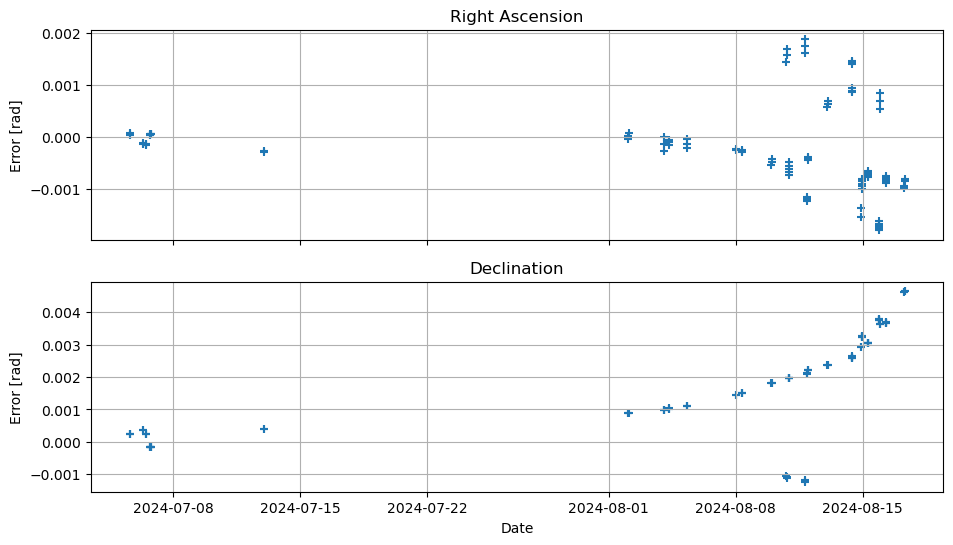

In [12]:
#Create plot
fig, (ax_ra, ax_dec) = plt.subplots(2, 1, figsize=(11, 6), sharex=True)

ax_ra.scatter(batch_times_utc, (jpl_RA - batch_RA), marker="+")
ax_dec.scatter(batch_times_utc, (jpl_DEC - batch_DEC), marker="+")

ax_ra.set_ylabel("Error [rad]")
ax_dec.set_ylabel("Error [rad]")
ax_dec.set_xlabel("Date")

ax_ra.grid()
ax_dec.grid()

ax_ra.set_title("Right Ascension")
ax_dec.set_title("Declination")

plt.show()

### Plotting observations
The `.plot_observations_sky()` method can be used to view a projection of the observations. 


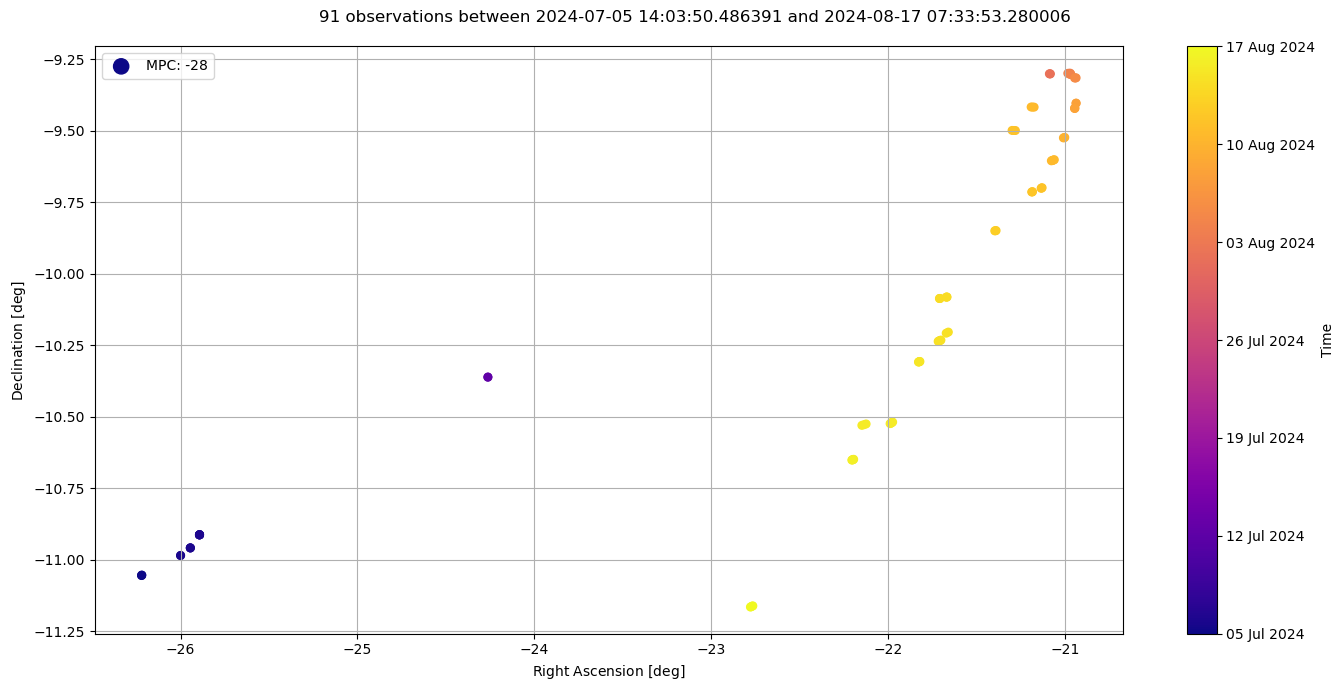

In [13]:
# Try some of the other projections: 'hammer', 'mollweide' and 'lambert'
fig = batch.plot_observations_sky()
plt.show()

### Retrieve Observation Collection
We can now retrieve the observation collection object, using the *to_tudat* method.

In [ ]:
observation_collection = batch.to_tudat(bodies, included_satellites=None, apply_star_catalog_debias = False)

In [ ]:
from tudatpy.util import result2array

# Retrieve the first and final observation epochs and add the buffer
epoch_start_nobuffer = batch.epoch_start
epoch_end_nobuffer = batch.epoch_end

print(f'Epoch Start (no buffer): {epoch_start_nobuffer}')
print(f'Epoch End (no buffer): {epoch_end_nobuffer}')

time_buffer = 86400

#number of iterations for our estimation
number_of_estimation_iterations = 8

# timestep of 300s for our estimation
timestep_global = 60*5

epoch_start_buffer = epoch_start_nobuffer - time_buffer 
epoch_end_buffer = epoch_end_nobuffer + time_buffer 

print(f'Epoch Start (with buffer): {epoch_start_buffer}')
print(f'Epoch End (with buffer): {epoch_end_buffer}')

In [ ]:
# Create radiation pressure settings
reference_area_radiation = 85 #m^2
radiation_pressure_coefficient = 1.2
occulting_bodies = ['Moon', 'Earth']
radiation_pressure_settings = environment_setup.radiation_pressure.cannonball(
    "Sun", reference_area_radiation, radiation_pressure_coefficient, occulting_bodies
)
# Add the radiation pressure interface to the environment
environment_setup.add_radiation_pressure_interface(bodies, "-28", radiation_pressure_settings)


# Define accelerations
accelerations = {
    "Sun": [
        propagation_setup.acceleration.point_mass_gravity(),
        propagation_setup.acceleration.relativistic_correction(use_schwarzschild=True),
        propagation_setup.acceleration.cannonball_radiation_pressure(),
    ],
    "Mercury": [propagation_setup.acceleration.point_mass_gravity()],
    "Venus": [propagation_setup.acceleration.point_mass_gravity()],
    "Earth": [propagation_setup.acceleration.point_mass_gravity()],
    "Moon": [propagation_setup.acceleration.point_mass_gravity()],
    "Mars": [propagation_setup.acceleration.point_mass_gravity()],
    "Jupiter": [propagation_setup.acceleration.point_mass_gravity()],
    "Saturn": [propagation_setup.acceleration.point_mass_gravity()],
    "Uranus": [propagation_setup.acceleration.point_mass_gravity()],
    "Neptune": [propagation_setup.acceleration.point_mass_gravity()],
}

# Set up the accelerations settings for each body, in this case only JUICE
acceleration_settings = {}
for body in batch.MPC_objects:
    acceleration_settings[str(body)] = accelerations

acceleration_settings
# create the acceleration models.
acceleration_models = propagation_setup.create_acceleration_models(
    bodies, acceleration_settings, bodies_to_propagate, central_bodies
)


In [ ]:
np.random.seed = 1

initial_position_offset = 0
initial_velocity_offset = 0

ephemeris_states = JUICE_horizons_query.cartesian('J2000')

spice_states = []
for epoch in batch_times:
    state = spice.get_body_cartesian_state_at_epoch(
        '-28',
        global_frame_origin,
        global_frame_orientation,
        "NONE",
        epoch,
    )

    spice_states.append(state)


initial_state = ephemeris_states[0,1:]

initial_state_spice = spice_states[0]
print(batch_times[0])
print(ephemeris_states[0,0])

print(initial_state)
print(initial_state_spice)
initial_guess = initial_state.copy()
initial_guess[0:3] += (2 * np.random.rand(3) - 1) * initial_position_offset
initial_guess[3:6] += (2 * np.random.rand(3) - 1) * initial_velocity_offset

initial_guess_spice = initial_state_spice.copy()
initial_guess_spice[0:3] += (2 * np.random.rand(3) - 1) * initial_position_offset
initial_guess_spice[3:6] += (2 * np.random.rand(3) - 1) * initial_velocity_offset

print("Error between the real initial state and our initial guess:")
print(initial_guess - initial_state)
print(initial_guess_spice - initial_state_spice)


x_horizons = [state[1] for state in ephemeris_states]
y_horizons = [state[2] for state in ephemeris_states]
z_horizons = [state[3] for state in ephemeris_states]

In [ ]:
# Create numerical integrator settings
integrator_settings = propagation_setup.integrator.\
    runge_kutta_fixed_step_size(initial_time_step=timestep_global,
                                coefficient_set=propagation_setup.integrator.CoefficientSets.rkdp_87)

# Terminate at the time of oldest observation
termination_condition = propagation_setup.propagator.time_termination(epoch_end_buffer)

# Create propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies=['Earth'],
    acceleration_models=acceleration_models,
    bodies_to_integrate=bodies_to_propagate,
    initial_states=initial_guess,
    initial_time=epoch_start_buffer,
    integrator_settings=integrator_settings,
    termination_settings=termination_condition,
)

# Create propagation settings
propagator_settings_spice = propagation_setup.propagator.translational(
    central_bodies=['Earth'],
    acceleration_models=acceleration_models,
    bodies_to_integrate=bodies_to_propagate,
    initial_states=initial_guess_spice,
    initial_time=epoch_start_buffer,
    integrator_settings=integrator_settings,
    termination_settings=termination_condition,
)

print(central_bodies)
print(acceleration_models)
print(bodies_to_propagate)
print(initial_guess)
print(epoch_start_buffer)
print(integrator_settings)
print(termination_condition)

In [ ]:
### VEHICLE BODY ###
# Create vehicle object
bodies.get("-28").mass = 1800 #kg

# Create simulation object and propagate the dynamics
dynamics_simulator = numerical_simulation.create_dynamics_simulator(
    bodies, propagator_settings
)

dynamics_simulator_spice = numerical_simulation.create_dynamics_simulator(
    bodies, propagator_settings_spice
)
# Extract the resulting state history and convert it to an ndarray
states = dynamics_simulator.propagation_results.state_history
states_array = result2array(states)

states_spice = dynamics_simulator_spice.propagation_results.state_history
states_array_spice = result2array(states_spice)
print(states_array)

In [ ]:
time_prop = [state[0] for state in states_array]

x_prop = [state[1] for state in states_array]
y_prop = [state[2] for state in states_array]
z_prop = [state[3] for state in states_array]


time_prop_spice = [state[0] for state in states_array_spice]

x_prop_spice = [state[1] for state in states_array_spice]
y_prop_spice = [state[2] for state in states_array_spice]
z_prop_spice = [state[3] for state in states_array_spice]

print(initial_state_spice[0])
print(x_prop_spice[0])

x_spice = [state[0] for state in spice_states]
y_spice= [state[1] for state in spice_states]
z_spice= [state[2] for state in spice_states]

plt.scatter(batch_times, x_horizons, s = 15, label = 'x horizons')
plt.scatter(batch_times, y_horizons, s = 15, label = 'y horizons')
plt.scatter(batch_times, z_horizons, s = 15, label = 'z horizons')

plt.scatter(time_prop, x_prop, s = 1, label = 'x prop')
plt.scatter(time_prop, y_prop, s = 1, label = 'y prop')
plt.scatter(time_prop, z_prop, s = 1, label = 'z prop')

plt.legend()
plt.show()

plt.scatter(batch_times, x_spice, s = 15, label = 'x spice')
plt.scatter(batch_times, y_spice, s = 15, label = 'y spice')
plt.scatter(batch_times, z_spice, s = 15, label = 'z spice')

plt.scatter(time_prop_spice, x_prop_spice, s = 1, label = 'x prop')
plt.scatter(time_prop_spice, y_prop_spice, s = 1, label = 'y prop')
plt.scatter(time_prop_spice, z_prop_spice, s = 1, label = 'z prop')

plt.legend()
plt.show()

states_array[:]
print("Error between the real spice final state and our final state:")
print(states_array[-1][1:] - ephemeris_states[-1][1:])
print(states_array_spice[-1][1:] - spice_states[-1][:])

In [ ]:
# Setup parameters settings to propagate the state transition matrix
parameter_settings = estimation_setup.parameter.initial_states(
    propagator_settings, bodies
)

# Create the parameters that will be estimated
parameters_to_estimate = estimation_setup.create_parameter_set(
    parameter_settings, bodies, propagator_settings
)

In [ ]:
# Set up the estimator
estimator = numerical_simulation.Estimator(
    bodies=bodies,
    estimated_parameters=parameters_to_estimate,
    observation_settings=observation_settings_list,
    propagator_settings=propagator_settings,
    integrate_on_creation=True,
)

# Save the true parameters to later analyse the error
truth_parameters = parameters_to_estimate.parameter_vector

# provide the observation collection as input, and limit number of iterations for estimation.
estimation_input = estimation.EstimationInput(
    observations_and_times=observation_collection,
    convergence_checker=estimation.estimation_convergence_checker(
        maximum_iterations=7,
    ),
)

estimation_input.define_estimation_settings(
    reintegrate_variational_equations=False,
    save_state_history_per_iteration=True)

estimation_output = estimator.perform_estimation(estimation_input)
residual_history = estimation_output.residual_history

print(estimation_output.simulation_results_per_iteration[-1])

###??????????
print(truth_parameters - parameters_to_estimate.parameter_vector)


earth_gravitational_parameter = bodies.get("Earth").gravitational_parameter
oe = element_conversion.cartesian_to_keplerian(
    cartesian_elements = parameters_to_estimate.parameter_vector,
    gravitational_parameter=earth_gravitational_parameter
)

print(f'Semi-Parameter:{oe[0]}')
print(f'f-element:{oe[1]}')
print(f'g-element:{np.degrees(oe[2])}')
print(f'h_element:{np.degrees(oe[3])}')
print(f'k-element:{np.degrees(oe[4])}')
print(f'True Longitude:{np.degrees(oe[5])}')

In [ ]:
# Number of columns and rows for our plot
number_of_columns = 2

number_of_rows = (
    int(number_of_estimation_iterations / number_of_columns)
    if number_of_estimation_iterations % number_of_columns == 0
    else int((number_of_estimation_iterations + 1) / number_of_columns)
)

fig, axs = plt.subplots(
    number_of_rows,
    number_of_columns,
    figsize=(9, 3.5 * number_of_rows),
    sharex=True,
    sharey=False,
)

# We cheat a little to get an approximate year out of our times (which are in seconds since J2000)
residual_times = (
    np.array(observation_collection.concatenated_times) / (86400 * 365.25) + 2000
)


# plot the residuals, split between RA and DEC types
for idx, ax in enumerate(fig.get_axes()):
    ax.grid()
    # we take every second
    ax.scatter(
        residual_times[::2],
        residual_history[
            ::2,
            idx,
        ],
        marker="+",
        s=60,
        label="Right Ascension",
    )
    ax.scatter(
        residual_times[1::2],
        residual_history[
            1::2,
            idx,
        ],
        marker="*",
        s=60,
        label="Declination",
    )
    ax.set_ylabel("Observation Residual [rad]")
    ax.set_title("Iteration " + str(idx + 1))

plt.tight_layout()

# add the year label for the x-axis
for col in range(number_of_columns):
    axs[int(number_of_rows - 1), col].set_xlabel("Year")

axs[0, 0].legend()

plt.show()

In [ ]:
# Define observation simulation times for each link (separated by steps of one minute)
observation_times = np.arange(epoch_start_nobuffer, epoch_end_nobuffer, 60)
observation_simulation_settings = list()

for link in link_list:
    observation_simulation_settings.append(observation.tabulated_simulation_settings(
        observation.angular_position_type,
        link,
        observation_times))

noise_level = 1e-5
observation.add_gaussian_noise_to_observable(
    observation_simulation_settings,
    noise_level,
    observation.angular_position_type
)

# Create viability setting
### Integrator and Termination Settings ###
# Create integrator settings
integrator_settings = propagation_setup.integrator.\
    runge_kutta_fixed_step_size(initial_time_step=60,
                                coefficient_set=propagation_setup.integrator.CoefficientSets.rkdp_87)
# Create termination settings
termination_settings = propagation_setup.propagator.time_termination(epoch_end_nobuffer)

### Propagator Settings ###
propagator_settings_simulation = propagation_setup.propagator. \
    translational(central_bodies=central_bodies,
                  acceleration_models=acceleration_models,
                  bodies_to_integrate=bodies_to_propagate,
                  initial_states=initial_guess_spice,
                  initial_time=epoch_start_buffer,
                  integrator_settings=integrator_settings,
                  termination_settings=termination_settings)

propagator_settings_simulation.processing_settings.set_integrated_result = True


# Create observation simulators
observation_simulators = estimation_setup.create_observation_simulators(
    observation_settings_list, bodies)
# Get JUICE simulated observations as ObservationCollection
juice_simulated_observations = estimation.simulate_observations(
    observation_simulation_settings,
    observation_simulators,
    bodies)

#print(np.degrees(juice_simulated_observations.concatenated_observations))
observation_times = np.unique(observation_collection.concatenated_times)

RA_obs_list = []
RA_sim_list = []
DEC_obs_list = []
DEC_sim_list = []

for j,i in enumerate(observation_collection.concatenated_observations):
    if (j % 2) == 0:
        RA_obs_list.append(observation_collection.concatenated_observations[j])
        RA_sim_list.append(juice_simulated_observations.concatenated_observations[j])
    elif j == 181:
        DEC_obs_list.append(observation_collection.concatenated_observations[j])
        DEC_sim_list.append(juice_simulated_observations.concatenated_observations[j])
    else:
        DEC_obs_list.append(observation_collection.concatenated_observations[j])
        DEC_sim_list.append(juice_simulated_observations.concatenated_observations[j])


plt.scatter(np.degrees(RA_obs_list), np.degrees(DEC_obs_list), label = 'data', s = 20)
plt.scatter(np.degrees(RA_sim_list), np.degrees(DEC_sim_list), label = 'simulated', s=20)
plt.xlabel('RA')
plt.ylabel('DEC')
plt.legend()

fig, ax1 = plt.subplots(1, 2, figsize=(9, 6))

ax1[0].scatter(np.degrees(RA_obs_list), np.degrees(DEC_obs_list), label = 'data', s = 20)
ax1[0].scatter(np.degrees(RA_sim_list), np.degrees(DEC_sim_list), label = 'simulated', s=20)

plt.legend()

ax1[1].scatter(observation_times, np.degrees(DEC_obs_list), label = 'data DEC', s = 20)
ax1[1].scatter(batch_times, np.degrees(DEC_sim_list), label = 'simulated DEC', s=20)
ax1[1].scatter(observation_times, np.degrees(RA_obs_list), label = 'data RA', s = 20)
ax1[1].scatter(batch_times, np.degrees(RA_sim_list), label = 'simulated RA', s=20)


ax1[0].set_xlabel(r'RA deg')
ax1[0].set_ylabel(r'DEC deg')
ax1[1].set_xlabel(r'Time')
ax1[1].set_ylabel(r'Angular Coord.')

plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# Corellation can be retrieved using the CovarianceAnalysisInput class:
covariance_input = estimation.CovarianceAnalysisInput(observation_collection)
covariance_output = estimator.compute_covariance(covariance_input)

correlations = covariance_output.correlations
estimated_param_names = ["x", "y", "z", "vx", "vy", "vz"]


fig, ax = plt.subplots(1, 1, figsize=(9, 7))

im = ax.imshow(correlations, cmap=cm.RdYlBu_r, vmin=-1, vmax=1)

ax.set_xticks(np.arange(len(estimated_param_names)), labels=estimated_param_names)
ax.set_yticks(np.arange(len(estimated_param_names)), labels=estimated_param_names)

# add numbers to each of the boxes
for i in range(len(estimated_param_names)):
    for j in range(len(estimated_param_names)):
        text = ax.text(
            j, i, round(correlations[i, j], 4), ha="center", va="center", color="w"
        )

cb = plt.colorbar(im)

ax.set_xlabel("Estimated Parameter")
ax.set_ylabel("Estimated Parameter")

fig.suptitle(f"Correlations for estimated parameters for {'JUICE'}")

fig.set_tight_layout(True)

In [ ]:
simulator_object = estimation_output.simulation_results_per_iteration[-1]
print(simulator_object)
state_history = simulator_object.dynamics_results.state_history
state_history_simulated_observations = dynamics_simulator.state_history

time2plt = np.vstack(list(state_history.keys()))
time2plt_normalized = (time2plt - time2plt[0]) / (3600*24)

juice_prop = np.vstack(list(state_history.values()))
juice_sim_obs = np.vstack(list(state_history_simulated_observations.values()))

fig, ax1 = plt.subplots(1, 1, figsize=(9, 6))

ax1.plot(time2plt_normalized, (juice_prop[:, 0] - juice_sim_obs[:, 0]), label=r'$\Delta x$')
ax1.plot(time2plt_normalized, (juice_prop[:, 1] - juice_sim_obs[:, 1]), label=r'$\Delta y$')
ax1.plot(time2plt_normalized, (juice_prop[:, 2] - juice_sim_obs[:, 2]), label=r'$\Delta z$')
ax1.plot(time2plt_normalized, np.linalg.norm((juice_prop[:, 0:3] - juice_sim_obs[:, 0:3]), axis=1), label=r'$||\Delta X||$')

ax1.set_title("Element-wise difference between true and estimated states")
ax1.set_xlabel(r'$Time$ [days]')
ax1.set_ylabel(r'$\Delta X$ [m]')
ax1.legend()

plt.tight_layout()
plt.show()